In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection, preprocessing, metrics, pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Objetivos

- Tentaremos criar e otimizar alguns modelos de **regressão** para a variável 'hdlngth'.

- Criar um **classificador** para 'Pop' e 'sex'.

In [233]:
df = pd.read_csv('data/possum.csv')
df.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


# Seperação dos dados

In [234]:
df_train, df_test = model_selection.train_test_split(df,
                                                     test_size=0.25,
                                                     random_state=42)

## Análisando variáveis alvo

<Axes: xlabel='chest', ylabel='belly'>

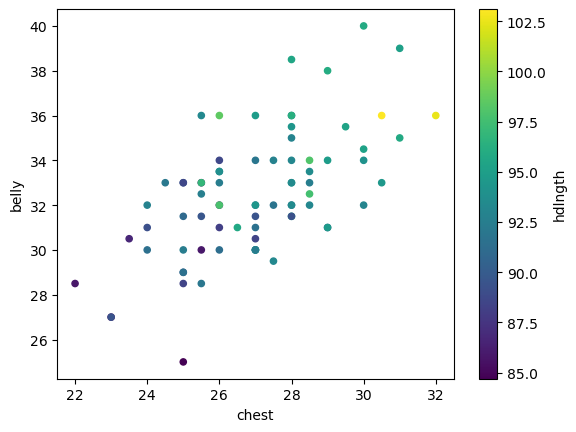

In [235]:
df_train.plot(kind='scatter',x='chest',y='belly',
              c='hdlngth')

In [236]:
df_train.select_dtypes('number').corr()['hdlngth'].sort_values(ascending=False)

hdlngth     1.000000
totlngth    0.733134
skullw      0.681317
chest       0.646412
belly       0.603422
footlgth    0.455711
eye         0.357662
taill       0.327997
age         0.229953
earconch    0.145779
site       -0.189924
case       -0.237881
Name: hdlngth, dtype: float64

Forte relação linear entre as variáveis totlngth, skullw, chest, belly com hdlngth

# Processando os dados

Dados categoricos serão transformados em numéricos e aplicaremos algumas normalizações nos dados para ajustar as escalas.

## Dados categóricos e valores nulos

Iremos aplicar o OrdinalEncoder nos dados categóricos e inputar os valores faltantes com a média da variável do respectivo grupo (sex, Pop)

### Pipeline de transformação

In [237]:
num_columns=['age', 'hdlngth', 'skullw', 'totlngth','taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

scaler_imputer_pipeline = pipeline.Pipeline([  # Faz transformações nas mesmas colunas
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', preprocessing.StandardScaler())
])

# Definição do ColumnTransformer
preprocessor = ColumnTransformer([('ordinal', preprocessing.OrdinalEncoder(), ['sex','Pop']), # Codificação ordinal
                                  ('scaler_imputer', scaler_imputer_pipeline, num_columns)], # Pipeline combinado para colunas numéricas
                                  verbose_feature_names_out=False) 


df_train = pd.DataFrame(preprocessor.fit_transform(df_train),
                        columns=preprocessor.get_feature_names_out(),
                        index=df_train.index)

df_train.head()

,sex,Pop,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
15,1.0,0.0,0.148802,-0.265683,-0.284865,-0.268027,-1.322258,1.063750,0.820338,-0.598860,0.494374,-0.173442
42,0.0,0.0,-0.956581,-0.714361,-0.442004,-1.386000,-2.592408,0.838526,0.328135,-1.558020,0.985598,-0.539075
40,0.0,0.0,0.701493,-1.163039,0.029413,-0.938811,-0.306139,-0.152459,-1.911388,0.839880,0.003149,-0.721892
9,0.0,0.0,1.254184,-0.209599,0.343692,0.514554,0.201921,0.590780,1.312541,-0.598860,0.248761,-0.173442
85,0.0,1.0,-0.403890,-1.219124,-1.164844,-0.156230,0.709981,-1.796594,-1.074643,-1.366188,-0.488076,-0.539075


# Modelos de predição

In [238]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [239]:
# Separação das variáveis alvo

X_train = df_train.drop('hdlngth',axis=1)
X_test = df_test.drop('hdlngth',axis=1)

y_train = df_train['hdlngth']
y_test = df_test['hdlngth']

In [240]:
lin_reg = linear_model.LinearRegression()
cross_score = -model_selection.cross_val_score(lin_reg,
                                               X_train,
                                               y_train,
                                               scoring='neg_root_mean_squared_error',
                                               cv=10)
print(f'Cross val results\n{pd.Series(cross_score).describe()}')

Cross val results
count    10.000000
mean      0.549771
std       0.148135
min       0.311007
25%       0.500692
50%       0.560852
75%       0.610483
max       0.787262
dtype: float64


In [241]:
tree_rmses = -model_selection.cross_val_score(DecisionTreeRegressor(),
                                              X_train,
                                              y_train,
                                              scoring="neg_root_mean_squared_error",
                                              cv=10)
print(f'Cross val results\n{pd.Series(tree_rmses).describe()}')

Cross val results
count    10.000000
mean      0.834966
std       0.347343
min       0.343590
25%       0.593190
50%       0.824422
75%       1.032463
max       1.447920
dtype: float64


In [242]:
forest_reg = RandomForestRegressor(random_state=42)
forest_rmses = -model_selection.cross_val_score(forest_reg,
                                X_train,
                                y_train,
                                scoring="neg_root_mean_squared_error",
                                cv=10)
print(f'Cross val results\n{pd.Series(forest_rmses).describe()}')

Cross val results
count    10.000000
mean      0.598106
std       0.136711
min       0.319882
25%       0.534596
50%       0.619375
75%       0.682735
max       0.799445
dtype: float64
